# Dodanie ścieżki do projektu

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Importowanie bibliotek

In [71]:
from src.scrapers import healthdata, koronawirusunas, meteostat, policjapl, rmf24, wiki_demo, wiki_urban
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from src.utils import save, paths
from pathlib import Path
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sklearn
from sklearn import cluster
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import unicodedata
import re
from sklearn.cluster import SpectralClustering

# Pobranie i zapisanie danych

In [3]:
update = False

if len(os.listdir(paths.get_path())) == 0 or update:
    data = {**healthdata.get_data(),
            **koronawirusunas.get_data(),
            **{"meteostat": pd.DataFrame(meteostat.get_data(end_date=str(datetime.datetime.now().date()), start_date="2020-01-01"))},
            **policjapl.scrape(),
            **wiki_demo.get_data(),
            **wiki_urban.get_data()
           }
    save.save_dataframes(data=data)
else:
    print("Data directory is not empty. propably data inside.")

Data directory is not empty. propably data inside.


# Załadowanie danych

In [4]:
policja = pd.read_csv(Path(paths.get_path(), "policjapl.csv"), index_col=1, parse_dates=True, dayfirst=True)
health = pd.read_csv(Path(paths.get_path(), "healthdata.csv"), index_col=2, parse_dates=True, dayfirst=True)
korona = pd.read_csv(Path(paths.get_path(), "koronawirusunas.csv"), index_col=0, parse_dates=True, dayfirst=True)
meteo = pd.read_csv(Path(paths.get_path(), "meteostat.csv"), index_col=1, parse_dates=True, dayfirst=True)

In [5]:
urban = pd.read_csv(Path(paths.get_path(), "urbanizacja.csv"), index_col=0, parse_dates=True, dayfirst=True)
demografia = pd.read_csv(Path(paths.get_path(), "demografia.csv"), index_col=0, parse_dates=True, dayfirst=True)

In [6]:
woj = koronawirusunas.SUB_SITES
wojewodztwa = pd.DataFrame()
for i in range(1, len(woj)):
    dat = pd.read_csv(Path(paths.get_path(), woj[i][12:] + ".csv"), index_col=0, parse_dates=True, dayfirst=True)
    dat.fillna(axis=1, inplace=True, value=0)
    dat["wojewodztwo"] = np.nan
    dat.fillna(axis=1, inplace=True, value=woj[i][12:])
    wojewodztwa = wojewodztwa.append(dat)

# Czyszczenie danych

## Czyszczenie meteo

In [7]:
meteo.head()

,Unnamed: 0,temperature,temperature_min,temperature_max,precipitation,snowfall,snowdepth,winddirection,windspeed,peakgust,sunshine,pressure
date,,,,,,,,,,,,
2020-01-01,0,1.4,0.8,5.6,1.0,NaN,NaN,267.0,17.4,NaN,NaN,1029.3
2020-01-02,1,0.8,-1.7,3.1,NaN,NaN,NaN,NaN,13.8,NaN,NaN,1026.5
2020-01-03,2,0.5,-4.1,4.6,NaN,NaN,NaN,205.0,6.4,NaN,NaN,1020.1
2020-01-04,3,3.7,1.6,5.3,1.0,NaN,NaN,258.0,20.7,NaN,NaN,1012.3
2020-01-05,4,0.4,-2.4,2.3,1.8,NaN,NaN,283.0,17.9,NaN,NaN,1025.8


In [8]:
meteo.drop(["snowfall", "snowdepth", "peakgust", "sunshine","precipitation","Unnamed: 0"], axis=1, inplace=True)
meteo.index.name = None
meteo.head()

,temperature,temperature_min,temperature_max,winddirection,windspeed,pressure
2020-01-01,1.4,0.8,5.6,267.0,17.4,1029.3
2020-01-02,0.8,-1.7,3.1,NaN,13.8,1026.5
2020-01-03,0.5,-4.1,4.6,205.0,6.4,1020.1
2020-01-04,3.7,1.6,5.3,258.0,20.7,1012.3
2020-01-05,0.4,-2.4,2.3,283.0,17.9,1025.8


In [9]:
meteo[meteo.isnull().any(axis=1)]

,temperature,temperature_min,temperature_max,winddirection,windspeed,pressure
2020-01-02,0.8,-1.7,3.1,NaN,13.8,1026.5
2020-01-13,4.8,2.0,NaN,NaN,NaN,NaN
2020-05-03,10.4,6.0,14.2,NaN,11.4,1011.8


In [10]:
meteo['winddirection'].fillna(meteo['winddirection'].mean(), inplace = True)
meteo['temperature_max'].fillna(meteo['temperature_max'].mean(), inplace = True)
meteo['pressure'].fillna(meteo['pressure'].mean(), inplace = True)
meteo['windspeed'].fillna(meteo['windspeed'].mean(), inplace = True)

In [11]:
meteo[meteo.isnull().any(axis=1)]

,temperature,temperature_min,temperature_max,winddirection,windspeed,pressure


## Czyszczenie health

In [12]:
health.columns

Index(['V1', 'location_name', 'allbed_mean', 'allbed_lower', 'allbed_upper',
       'ICUbed_mean', 'ICUbed_lower', 'ICUbed_upper', 'InvVen_mean',
       'InvVen_lower', 'InvVen_upper', 'deaths_mean', 'deaths_lower',
       'deaths_upper', 'admis_mean', 'admis_lower', 'admis_upper',
       'newICU_mean', 'newICU_lower', 'newICU_upper', 'totdea_mean',
       'totdea_lower', 'totdea_upper', 'bedover_mean', 'bedover_lower',
       'bedover_upper', 'icuover_mean', 'icuover_lower', 'icuover_upper',
       'deaths_mean_smoothed', 'deaths_lower_smoothed',
       'deaths_upper_smoothed', 'totdea_mean_smoothed',
       'totdea_lower_smoothed', 'totdea_upper_smoothed', 'mobility_data_type',
       'mobility_composite', 'total_tests_data_type', 'total_tests',
       'confirmed_infections', 'est_infections_mean', 'est_infections_lower',
       'est_infections_upper'],
      dtype='object')

In [13]:
health = health.drop(health[health.index > "2020-05-20"].index)
health = health[health.location_name == "Poland"]
health = health[["allbed_mean", "ICUbed_mean", "deaths_mean", "admis_mean", "newICU_mean", 
                 "totdea_mean", "bedover_mean", "icuover_mean", 
                 "mobility_composite", "total_tests", "confirmed_infections"]]
health.index.name = None

In [14]:
health.tail()

,allbed_mean,ICUbed_mean,deaths_mean,admis_mean,newICU_mean,totdea_mean,bedover_mean,icuover_mean,mobility_composite,total_tests,confirmed_infections
2020-05-16,434.829267,136.513487,8.0,46.936025,14.164300,915.0,0.0,0.0,-29.270980,19742.765892,322.594580
2020-05-17,409.154800,130.489962,10.0,46.770750,14.418250,925.0,0.0,0.0,-29.275501,19953.899272,322.593956
2020-05-18,397.374917,128.283183,11.0,49.147754,14.964267,936.0,0.0,0.0,-29.306475,20124.802374,345.489340
2020-05-19,393.730192,126.842613,12.0,47.749646,14.441683,948.0,0.0,0.0,-29.355494,20262.868461,383.297532
2020-05-20,389.284775,124.126312,14.0,45.355958,13.882433,962.0,0.0,0.0,-29.355494,20374.591746,410.496531


In [15]:
health[health.isnull().any(axis=1)]

,allbed_mean,ICUbed_mean,deaths_mean,admis_mean,newICU_mean,totdea_mean,bedover_mean,icuover_mean,mobility_composite,total_tests,confirmed_infections
2019-12-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2019-12-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2019-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2019-12-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2019-12-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.680087,NaN,NaN
2020-02-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.429874,NaN,NaN
2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.156718,NaN,NaN
2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.800878,NaN,NaN


In [16]:
health.fillna(0, inplace = True)

In [17]:
health[health.isnull().any(axis=1)]

,allbed_mean,ICUbed_mean,deaths_mean,admis_mean,newICU_mean,totdea_mean,bedover_mean,icuover_mean,mobility_composite,total_tests,confirmed_infections


## Czyszczenie policja

In [18]:
policja.head()

,Unnamed: 0,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach
Data,,,,,,,,
2020-05-27,0,16226,596,311,186,60,6,65
2020-05-26,1,15783,562,281,144,48,3,54
2020-05-25,2,15489,546,250,178,57,6,71
2020-05-24,3,13749,630,166,284,50,10,66
2020-05-23,4,16946,625,180,242,50,5,57


In [19]:
policja.index.name = None
policja.head()

,Unnamed: 0,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach
2020-05-27,0,16226,596,311,186,60,6,65
2020-05-26,1,15783,562,281,144,48,3,54
2020-05-25,2,15489,546,250,178,57,6,71
2020-05-24,3,13749,630,166,284,50,10,66
2020-05-23,4,16946,625,180,242,50,5,57


In [20]:
policja[policja.isnull().any(axis=1)]

,Unnamed: 0,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach


## Czyszczenie korona

In [21]:
korona.head()

,smp,testy,testyl,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.53,4.70,NaN,NaN,NaN,NaN
2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.05,6.90,NaN,NaN,NaN,NaN
2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.24,4.46,NaN,NaN,NaN,NaN
2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.95,7.81,NaN,NaN,NaN,NaN
2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.57,22.21,NaN,NaN,NaN,NaN


In [22]:
korona.tail()

,smp,testy,testyl,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
2020-05-24,21326.0,767441.0,701969.0,21326.0,11136.0,996.0,9194.0,-45.29,-13.33,2242.0,79326.0,NaN,19529.0
2020-05-25,21631.0,779576.0,712675.0,21631.0,11348.0,1007.0,9276.0,-38.50,-11.21,2268.0,78259.0,NaN,19587.0
2020-05-26,22074.0,801753.0,733701.0,22074.0,11030.0,1024.0,10020.0,-31.65,-5.06,2171.0,78864.0,NaN,19139.0
2020-05-27,22473.0,824774.0,753675.0,22473.0,11115.0,1028.0,10330.0,NaN,NaN,2320.0,79007.0,NaN,19682.0
2020-05-28,22825.0,846732.0,773625.0,22825.0,11227.0,1038.0,10560.0,NaN,NaN,2248.0,79818.0,NaN,19373.0


### Wypełnienie nan

In [23]:
korona['kwar_z'].fillna(0, inplace=True)
korona.fillna(method='ffill', inplace=True)
korona.fillna(0, inplace=True)
korona

,smp,testy,testyl,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
2020-02-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.53,4.70,0.0,0.0,0.0,0.0
2020-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.05,6.90,0.0,0.0,0.0,0.0
2020-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.24,4.46,0.0,0.0,0.0,0.0
2020-02-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.95,7.81,0.0,0.0,0.0,0.0
2020-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.57,22.21,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-24,21326.0,767441.0,701969.0,21326.0,11136.0,996.0,9194.0,-45.29,-13.33,2242.0,79326.0,0.0,19529.0
2020-05-25,21631.0,779576.0,712675.0,21631.0,11348.0,1007.0,9276.0,-38.50,-11.21,2268.0,78259.0,0.0,19587.0
2020-05-26,22074.0,801753.0,733701.0,22074.0,11030.0,1024.0,10020.0,-31.65,-5.06,2171.0,78864.0,0.0,19139.0
2020-05-27,22473.0,824774.0,753675.0,22473.0,11115.0,1028.0,10330.0,-31.65,-5.06,2320.0,79007.0,0.0,19682.0


In [24]:
korona[korona.isnull().any(axis=1)]

,smp,testy,testyl,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor


##  Czyszczenie urbanizacja

In [25]:
def strip_accents(text):
    print(text[1])
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode("utf8")

In [26]:
urban[urban.isnull().any(axis=1)]

,TERYT,Województwo,Miasta – siedziby województw,"Powierzchnia[km²], 31.12.2018[3]",Ludność(31 XII 2018)[4],Gęstość zaludnienia (osób/km²),Poziomurbanizacji(31 XII 2018),Stopa bezrobocia(I 2019)[5],PKB na 1 mieszkańca(31 XII 2018) [zł][3],Wyróżnik województwa na tablicachrejestracyjnych


In [27]:
urban = urban.drop(columns=["TERYT", "Miasta – siedziby województw","Wyróżnik województwa na tablicachrejestracyjnych"])

In [28]:
urban

,Województwo,"Powierzchnia[km²], 31.12.2018[3]",Ludność(31 XII 2018)[4],Gęstość zaludnienia (osób/km²),Poziomurbanizacji(31 XII 2018),Stopa bezrobocia(I 2019)[5],PKB na 1 mieszkańca(31 XII 2018) [zł][3]
0,dolnośląskie,19 947,2 901 225,14545,"68,61%","5,4%",57 228
1,kujawsko-pomorskie,17 972,2 077 775,11562,"59,09%","9,2%",41 875
2,lubelskie,25 122,2 117 629,8429,"46,46%","8,4%",35 712
3,lubuskie,13 988,1 014 548,7253,"64,95%","6,2%",42 755
4,łódzkie,18 219,2 466 322,13537,"62,55%","6,3%",48 126
5,małopolskie,15 183,3 400 577,22398,"48,19%","4,9%",47 272
6,mazowieckie,35 558,5 403 412,15196,"64,40%","5,1%",83 123
7,opolskie,9412,986 506,10482,"53,30%","6,6%",41 080
8,podkarpackie,17 846,2 129 015,11930,"41,09%","9,1%",36 088
9,podlaskie,20 187,1 181 533,5853,"60,79%","8,1%",37 077


In [29]:
urban.rename(columns={
    "Województwo": "wojewodztwo",
    "Powierzchnia[km²], 31.12.2018[3]": "powierzchnina",
    "Ludność(31 XII 2018)[4]": "ludnosc",
    "Gęstość zaludnienia (osób/km²)": "gestosc_zal",
    "Poziomurbanizacji(31 XII 2018)": "urbanizacja",
    "Stopa bezrobocia(I\xa02019)[5]": "stopa_bezrobocia",
    "PKB na 1 mieszkańca(31 XII 2018) [zł][3]": "pdb_na_miesz"
}, inplace=True)

In [30]:
urban.columns
urban.dtypes

wojewodztwo         object
powierzchnina       object
ludnosc             object
gestosc_zal          int64
urbanizacja         object
stopa_bezrobocia    object
pdb_na_miesz        object
dtype: object

In [31]:
def remove_spaces(text):
    match = re.match(r"[0-9]+(,*.*[0-9][0-9]?)?", str(text))
    text = match[0].replace(" ", "")
    text = re.sub(r"\s+", "", text)
    text = re.sub(r",", ".", text)
    return text

def fix_num(series):
    return series.apply(remove_spaces)

cols = urban.columns.drop('wojewodztwo', 'gestosc_zal')
urban[cols] = urban[cols].apply(fix_num)
urban[cols] = urban[cols].apply(pd.to_numeric)

In [32]:
urban

,wojewodztwo,powierzchnina,ludnosc,gestosc_zal,urbanizacja,stopa_bezrobocia,pdb_na_miesz
0,dolnośląskie,19947,2901225,14545,68.61,5.4,57228
1,kujawsko-pomorskie,17972,2077775,11562,59.09,9.2,41875
2,lubelskie,25122,2117629,8429,46.46,8.4,35712
3,lubuskie,13988,1014548,7253,64.95,6.2,42755
4,łódzkie,18219,2466322,13537,62.55,6.3,48126
5,małopolskie,15183,3400577,22398,48.19,4.9,47272
6,mazowieckie,35558,5403412,15196,64.40,5.1,83123
7,opolskie,9412,986506,10482,53.30,6.6,41080
8,podkarpackie,17846,2129015,11930,41.09,9.1,36088
9,podlaskie,20187,1181533,5853,60.79,8.1,37077


## Czyszczenie demografia

In [33]:
demografia = demografia.drop(columns=["Siedziba władz", "Powierzchniaw km²", "Ludność(2017[2])", "Gęstośćzaludn.na km²"])

In [34]:
demografia.head(20)

,Województwo,Miasta,II stopień adm.,II stopień adm..1,Gminy,Gminy.1,Gminy.2,Gminy.3
NaN,Województwo,Miasta,powiaty,m. na prawach powiatu,ogółem,miejskie,wiejskie,miejsko-wiejskie
0.0,dolnośląskie,91.0,26.0,4.0,169.0,35.0,78.0,56.0
1.0,kujawsko-pomorskie,52.0,19.0,4.0,144.0,17.0,92.0,35.0
2.0,lubelskie,48.0,20.0,4.0,213.0,20.0,165.0,28.0
3.0,lubuskie,43.0,12.0,2.0,82.0,9.0,39.0,34.0
4.0,łódzkie,46.0,21.0,3.0,177.0,18.0,131.0,28.0
5.0,małopolskie,62.0,19.0,3.0,182.0,14.0,120.0,48.0
6.0,mazowieckie,89.0,37.0,5.0,314.0,35.0,225.0,54.0
7.0,opolskie,36.0,11.0,1.0,71.0,3.0,35.0,33.0
8.0,podkarpackie,51.0,21.0,4.0,160.0,16.0,109.0,35.0


In [35]:
demografia.columns

Index(['Województwo', 'Miasta', 'II stopień adm.', 'II stopień adm..1',
       'Gminy', 'Gminy.1', 'Gminy.2', 'Gminy.3'],
      dtype='object')

In [36]:
demografia.rename(columns={
    "Województwo": "wojewodztwo",
    "Miasta": "miasta",
    "II stopień adm.": "powiaty",
    "II stopień adm..1": "m_powiaty",
    "Gminy": "gminy_ogolem",
    "Gminy.1": "miejskie",
    "Gminy.2": "wiejskie",
    "Gminy.3": "miejsko_wiejskie"
}, inplace=True)

In [37]:
demografia.head(5)

,wojewodztwo,miasta,powiaty,m_powiaty,gminy_ogolem,miejskie,wiejskie,miejsko_wiejskie
NaN,Województwo,Miasta,powiaty,m. na prawach powiatu,ogółem,miejskie,wiejskie,miejsko-wiejskie
0.0,dolnośląskie,91.0,26.0,4.0,169.0,35.0,78.0,56.0
1.0,kujawsko-pomorskie,52.0,19.0,4.0,144.0,17.0,92.0,35.0
2.0,lubelskie,48.0,20.0,4.0,213.0,20.0,165.0,28.0
3.0,lubuskie,43.0,12.0,2.0,82.0,9.0,39.0,34.0


In [38]:
demografia.drop([np.nan, 16,17], inplace=True)

## Łączenie danych

### demografia, urbanizacja, suma chorych

In [39]:
df2 = urban.merge(demografia, on=["wojewodztwo"], how="outer")
df2["wojewodztwo"] = df2["wojewodztwo"].apply(strip_accents)

o
u
u
u
ó
a
a
p
o
o
o
l
w
a
i
a


In [40]:
df2.replace({"odzkie": "lodzkie",
             "maopolskie": "malopolskie"}, inplace=True)

In [41]:
df2.head(20)

,wojewodztwo,powierzchnina,ludnosc,gestosc_zal,urbanizacja,stopa_bezrobocia,pdb_na_miesz,miasta,powiaty,m_powiaty,gminy_ogolem,miejskie,wiejskie,miejsko_wiejskie
0,dolnoslaskie,19947,2901225,14545,68.61,5.4,57228,91.0,26.0,4.0,169.0,35.0,78.0,56.0
1,kujawsko-pomorskie,17972,2077775,11562,59.09,9.2,41875,52.0,19.0,4.0,144.0,17.0,92.0,35.0
2,lubelskie,25122,2117629,8429,46.46,8.4,35712,48.0,20.0,4.0,213.0,20.0,165.0,28.0
3,lubuskie,13988,1014548,7253,64.95,6.2,42755,43.0,12.0,2.0,82.0,9.0,39.0,34.0
4,lodzkie,18219,2466322,13537,62.55,6.3,48126,46.0,21.0,3.0,177.0,18.0,131.0,28.0
5,malopolskie,15183,3400577,22398,48.19,4.9,47272,62.0,19.0,3.0,182.0,14.0,120.0,48.0
6,mazowieckie,35558,5403412,15196,64.40,5.1,83123,89.0,37.0,5.0,314.0,35.0,225.0,54.0
7,opolskie,9412,986506,10482,53.30,6.6,41080,36.0,11.0,1.0,71.0,3.0,35.0,33.0
8,podkarpackie,17846,2129015,11930,41.09,9.1,36088,51.0,21.0,4.0,160.0,16.0,109.0,35.0
9,podlaskie,20187,1181533,5853,60.79,8.1,37077,40.0,14.0,3.0,118.0,13.0,78.0,27.0


In [42]:
df2 = df2.merge(wojewodztwa.groupby(['wojewodztwo']).sum().reset_index(), on=["wojewodztwo"], how="outer") 

In [43]:
wojewodztwa.groupby(['wojewodztwo']).sum().reset_index()

,wojewodztwo,zar,chor,zgo,wyl
0,dolnoslaskie,87077,55266.0,3046.0,23853.0
1,kujawsko-pomorskie,27408,13569.0,1453.0,10543.0
2,lodzkie,53390,28425.0,1611.0,22452.0
3,lubelskie,20099,8674.0,706.0,10283.0
4,lubuskie,5211,2064.0,0.0,3128.0
5,malopolskie,48582,28876.0,1479.0,16550.0
6,mazowieckie,137123,81543.0,9324.0,43744.0
7,opolskie,21681,14387.0,1384.0,5878.0
8,podkarpackie,16870,5712.0,1207.0,9951.0
9,podlaskie,18503,7905.0,269.0,10035.0


In [44]:
df2.head(20)

,wojewodztwo,powierzchnina,ludnosc,gestosc_zal,urbanizacja,stopa_bezrobocia,pdb_na_miesz,miasta,powiaty,m_powiaty,gminy_ogolem,miejskie,wiejskie,miejsko_wiejskie,zar,chor,zgo,wyl
0,dolnoslaskie,19947,2901225,14545,68.61,5.4,57228,91.0,26.0,4.0,169.0,35.0,78.0,56.0,87077,55266.0,3046.0,23853.0
1,kujawsko-pomorskie,17972,2077775,11562,59.09,9.2,41875,52.0,19.0,4.0,144.0,17.0,92.0,35.0,27408,13569.0,1453.0,10543.0
2,lubelskie,25122,2117629,8429,46.46,8.4,35712,48.0,20.0,4.0,213.0,20.0,165.0,28.0,20099,8674.0,706.0,10283.0
3,lubuskie,13988,1014548,7253,64.95,6.2,42755,43.0,12.0,2.0,82.0,9.0,39.0,34.0,5211,2064.0,0.0,3128.0
4,lodzkie,18219,2466322,13537,62.55,6.3,48126,46.0,21.0,3.0,177.0,18.0,131.0,28.0,53390,28425.0,1611.0,22452.0
5,malopolskie,15183,3400577,22398,48.19,4.9,47272,62.0,19.0,3.0,182.0,14.0,120.0,48.0,48582,28876.0,1479.0,16550.0
6,mazowieckie,35558,5403412,15196,64.40,5.1,83123,89.0,37.0,5.0,314.0,35.0,225.0,54.0,137123,81543.0,9324.0,43744.0
7,opolskie,9412,986506,10482,53.30,6.6,41080,36.0,11.0,1.0,71.0,3.0,35.0,33.0,21681,14387.0,1384.0,5878.0
8,podkarpackie,17846,2129015,11930,41.09,9.1,36088,51.0,21.0,4.0,160.0,16.0,109.0,35.0,16870,5712.0,1207.0,9951.0
9,podlaskie,20187,1181533,5853,60.79,8.1,37077,40.0,14.0,3.0,118.0,13.0,78.0,27.0,18503,7905.0,269.0,10035.0


In [45]:
cols = df2.columns.drop('wojewodztwo')
df2[cols] = df2[cols].apply(pd.to_numeric)

In [46]:
df2.head()

,wojewodztwo,powierzchnina,ludnosc,gestosc_zal,urbanizacja,stopa_bezrobocia,pdb_na_miesz,miasta,powiaty,m_powiaty,gminy_ogolem,miejskie,wiejskie,miejsko_wiejskie,zar,chor,zgo,wyl
0,dolnoslaskie,19947,2901225,14545,68.61,5.4,57228,91.0,26.0,4.0,169.0,35.0,78.0,56.0,87077,55266.0,3046.0,23853.0
1,kujawsko-pomorskie,17972,2077775,11562,59.09,9.2,41875,52.0,19.0,4.0,144.0,17.0,92.0,35.0,27408,13569.0,1453.0,10543.0
2,lubelskie,25122,2117629,8429,46.46,8.4,35712,48.0,20.0,4.0,213.0,20.0,165.0,28.0,20099,8674.0,706.0,10283.0
3,lubuskie,13988,1014548,7253,64.95,6.2,42755,43.0,12.0,2.0,82.0,9.0,39.0,34.0,5211,2064.0,0.0,3128.0
4,lodzkie,18219,2466322,13537,62.55,6.3,48126,46.0,21.0,3.0,177.0,18.0,131.0,28.0,53390,28425.0,1611.0,22452.0


### Df

In [47]:
df = pd.merge(policja, meteo, how='outer', left_index=True, right_index=True)
df = pd.merge(df, health, how='outer', left_index=True, right_index=True)
df = pd.merge(df, korona, how='outer', left_index=True, right_index=True)

In [48]:
df.iloc[0]

Unnamed: 0                         NaN
Interwencje                        NaN
Zatrzymani na gorącym uczynku      NaN
Zatrzymani poszukiwani             NaN
Zatrzymani nietrzeźwi kierujący    NaN
Wypadki drogowe                    NaN
Zabici w wypadkach                 NaN
Ranni w wypadkach                  NaN
temperature                        NaN
temperature_min                    NaN
temperature_max                    NaN
winddirection                      NaN
windspeed                          NaN
pressure                           NaN
allbed_mean                        0.0
ICUbed_mean                        0.0
deaths_mean                        0.0
admis_mean                         0.0
newICU_mean                        0.0
totdea_mean                        0.0
bedover_mean                       0.0
icuover_mean                       0.0
mobility_composite                 0.0
total_tests                        0.0
confirmed_infections               0.0
smp                      

## Czyszczenie df

In [49]:
df.fillna(method='ffill', inplace=True)
df.head()

,Unnamed: 0,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
2019-12-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Usunięcie danych sprzed 01.01.2020

In [50]:
df.drop(df[df.index < "2020-01-01"].index, inplace = True)
df

,Unnamed: 0,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
2020-01-01,12.0,19145.0,734.0,188.0,332.0,42.0,1.0,46.0,1.4,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,11.0,14654.0,513.0,333.0,166.0,60.0,5.0,67.0,0.8,-1.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,10.0,15507.0,468.0,405.0,122.0,62.0,3.0,69.0,0.5,-4.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,9.0,14528.0,435.0,176.0,135.0,59.0,4.0,64.0,3.7,1.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,8.0,11948.0,457.0,185.0,146.0,44.0,4.0,54.0,0.4,-2.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-24,3.0,13749.0,630.0,166.0,284.0,50.0,10.0,66.0,13.0,8.0,...,21326.0,11136.0,996.0,9194.0,-45.29,-13.33,2242.0,79326.0,0.0,19529.0
2020-05-25,2.0,15489.0,546.0,250.0,178.0,57.0,6.0,71.0,12.2,8.0,...,21631.0,11348.0,1007.0,9276.0,-38.50,-11.21,2268.0,78259.0,0.0,19587.0
2020-05-26,1.0,15783.0,562.0,281.0,144.0,48.0,3.0,54.0,13.9,8.0,...,22074.0,11030.0,1024.0,10020.0,-31.65,-5.06,2171.0,78864.0,0.0,19139.0
2020-05-27,0.0,16226.0,596.0,311.0,186.0,60.0,6.0,65.0,14.8,8.0,...,22473.0,11115.0,1028.0,10330.0,-31.65,-5.06,2320.0,79007.0,0.0,19682.0


In [51]:
df[df.isnull().any(axis=1)].head()

,Unnamed: 0,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
2020-01-01,12.0,19145.0,734.0,188.0,332.0,42.0,1.0,46.0,1.4,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,11.0,14654.0,513.0,333.0,166.0,60.0,5.0,67.0,0.8,-1.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,10.0,15507.0,468.0,405.0,122.0,62.0,3.0,69.0,0.5,-4.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,9.0,14528.0,435.0,176.0,135.0,59.0,4.0,64.0,3.7,1.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,8.0,11948.0,457.0,185.0,146.0,44.0,4.0,54.0,0.4,-2.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df.fillna(0,inplace=True)
df[df.isnull().any(axis=1)].head()

,Unnamed: 0,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor


## Dodanie kolumny z datą od rozpoczęcia ( potrzebna do regresji )

In [53]:
df["date"] = (df.index - df.index.min())  / np.timedelta64(1,'D')

# Współcznniki korelacji

In [54]:
def highlight(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    l = []
    for v in s:
        if abs(v) > 0.85 and abs(v) != 1:
            l.append('background-color: red')
        elif abs(v) > 0.75 and abs(v) != 1:
            l.append('background-color: yellow')
        else: 
            l.append('')
    return l

## Pearson

In [55]:
cor_pearson = df.corr(method="pearson")
cor_pearson.style.apply(highlight)

cor_pearson = cor_pearson.where(np.triu(np.ones(cor_pearson.shape)).astype(np.bool))
cor_pearson = cor_pearson.stack().reset_index()
cor_pearson.columns = ['Row','Column','Value']
cor_pearson['Value'] = pd.to_numeric(cor_pearson['Value'])
to_check_prearson = cor_pearson[(abs(cor_pearson['Value']) >= 0.75) & (abs(cor_pearson['Value']) != 1)]

In [56]:
to_check_prearson.head(50)

,Row,Column,Value
102,Zatrzymani na gorącym uczynku,pojazdem,0.811756
106,Zatrzymani na gorącym uczynku,nadzor,-0.780089
136,Zatrzymani poszukiwani,pojazdem,0.755795
177,Wypadki drogowe,Ranni w wypadkach,0.969541
201,Wypadki drogowe,pojazdem,0.762616
262,Ranni w wypadkach,pojazdem,0.777819
269,temperature,temperature_min,0.829823
270,temperature,temperature_max,0.966972
281,temperature,total_tests,0.765077
283,temperature,smp,0.754846


## Kendall

In [57]:
cor_pearson = df.corr(method="kendall")
cor_pearson.style.apply(highlight)

,Unnamed: 0,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,temperature_max,winddirection,windspeed,pressure,allbed_mean,ICUbed_mean,deaths_mean,admis_mean,newICU_mean,totdea_mean,bedover_mean,icuover_mean,mobility_composite,total_tests,confirmed_infections,smp,testy,testyl,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor,date
Unnamed: 0,1.000000,-0.112104,-0.013499,-0.042359,-0.028924,-0.033496,-0.039823,-0.025491,-0.126391,-0.096959,-0.113243,0.012312,-0.015654,-0.043444,-0.055809,-0.044032,-0.043042,-0.047569,-0.046841,-0.060820,nan,nan,0.017213,-0.072804,-0.090980,-0.079384,-0.079481,-0.040621,-0.079384,-0.083423,-0.065171,-0.088156,-0.032246,-0.022157,-0.028969,-0.021244,-0.024255,-0.017178,-0.083189
Interwencje,-0.112104,1.000000,0.123689,-0.001166,0.205888,0.138364,0.077209,0.112642,0.334159,0.272174,0.314156,-0.030423,-0.113945,0.001344,0.239953,0.230962,0.274207,0.254184,0.246590,0.233393,nan,nan,-0.113836,0.240768,0.282468,0.241607,0.241692,0.252775,0.241607,0.332890,0.232293,0.334726,-0.069327,-0.053410,0.237271,0.233133,-0.237247,0.134401,0.219825
Zatrzymani na gorącym uczynku,-0.013499,0.123689,1.000000,0.345886,0.480948,0.421845,0.145516,0.418537,-0.006656,0.166067,-0.061255,0.058676,-0.055471,-0.169478,-0.308769,-0.294156,-0.251821,-0.325029,-0.336526,-0.136725,nan,nan,0.504646,-0.135121,-0.232587,-0.131610,-0.131504,0.214824,-0.131610,0.040314,-0.136683,0.044449,0.507116,0.522861,-0.257498,-0.388516,-0.379011,-0.501184,-0.082269
Zatrzymani poszukiwani,-0.042359,-0.001166,0.345886,1.000000,-0.096490,0.535084,0.021702,0.518300,-0.161134,-0.003063,-0.218464,0.047818,0.007374,-0.187570,-0.418745,-0.415782,-0.317059,-0.438110,-0.448775,-0.307702,nan,nan,0.518082,-0.298425,-0.335043,-0.303568,-0.303552,-0.032915,-0.303568,-0.159928,-0.306005,-0.161766,0.584970,0.603794,-0.376697,-0.481702,-0.348579,-0.560456,-0.270821
Zatrzymani nietrzeźwi kierujący,-0.028924,0.205888,0.480948,-0.096490,1.000000,0.112284,0.205271,0.129018,0.183154,0.228092,0.158911,0.046849,-0.084013,-0.101291,0.022530,0.031687,0.008969,-0.006715,-0.000604,0.093948,nan,nan,0.161652,0.097633,0.045808,0.097931,0.098025,0.261904,0.097931,0.232162,0.093199,0.234466,0.151422,0.136598,0.032050,-0.057770,-0.277943,-0.153327,0.118161
Wypadki drogowe,-0.033496,0.138364,0.421845,0.535084,0.112284,1.000000,0.217085,0.858376,-0.048061,0.103861,-0.116588,-0.001266,-0.062246,-0.236823,-0.355045,-0.347714,-0.328501,-0.378967,-0.388555,-0.263589,nan,nan,0.486270,-0.240119,-0.315069,-0.242253,-0.242339,0.041720,-0.242253,-0.110382,-0.262408,-0.111538,0.558254,0.562891,-0.310560,-0.450352,-0.323573,-0.513497,-0.222399
Zabici w wypadkach,-0.039823,0.077209,0.145516,0.021702,0.205271,0.217085,1.000000,0.190650,0.023831,0.079669,-0.015003,0.041927,0.082570,-0.097364,-0.066398,-0.059945,-0.078318,-0.077986,-0.073424,-0.057906,nan,nan,0.110329,-0.050564,-0.062740,-0.043222,-0.043324,0.024637,-0.043222,-0.013095,-0.056149,-0.014065,0.120913,0.106723,-0.053220,-0.105087,-0.037839,-0.115918,-0.037085
Ranni w wypadkach,-0.025491,0.112642,0.418537,0.518300,0.129018,0.858376,0.190650,1.000000,-0.084707,0.077840,-0.139380,-0.009132,-0.068480,-0.230382,-0.374275,-0.363819,-0.339574,-0.402502,-0.412133,-0.278326,nan,nan,0.516183,-0.251193,-0.332041,-0.256018,-0.255905,0.034422,-0.256018,-0.119265,-0.277108,-0.122501,0.570350,0.575760,-0.320346,-0.464883,-0.332065,-0.527424,-0.227328
temperature,-0.126391,0.334159,-0.006656,-0.161134,0.183154,-0.048061,0.023831,-0.084707,1.000000,0.647593,0.838817,0.033950,-0.044330,-0.127052,0.505295,0.505351,0.500851,0.491212,0.483521,0.552090,nan,nan,-0.283344,0.565285,0.526161,0.564186,0.564056,0.473016,0.564186,0.591310,0.553950,0.594763,-0.245554,-0.253251,0.527404,0.427539,-0.070145,0.329257,0.549132
temperature_min,-0.096959,0.272174,0.166067,-0.003063,0.228092,0.103861,0.079669,0.077840,0.647593,1.000000,

In [58]:
cor_pearson = df.corr(method="kendall")
cor_pearson.style.apply(highlight)

cor_pearson = cor_pearson.where(np.triu(np.ones(cor_pearson.shape)).astype(np.bool))
cor_pearson = cor_pearson.stack().reset_index()
cor_pearson.columns = ['Row','Column','Value']
cor_pearson['Value'] = pd.to_numeric(cor_pearson['Value'])
to_check_kendall = cor_pearson[(abs(cor_pearson['Value']) >= 0.75) & (abs(cor_pearson['Value']) != 1)]
to_check_kendall.head(50)

,Row,Column,Value
177,Wypadki drogowe,Ranni w wypadkach,0.858376
270,temperature,temperature_max,0.838817
428,allbed_mean,ICUbed_mean,0.968599
429,allbed_mean,deaths_mean,0.823878
430,allbed_mean,admis_mean,0.886805
431,allbed_mean,newICU_mean,0.919280
435,allbed_mean,confirmed_infections,0.754098
445,allbed_mean,hosp,0.897357
446,allbed_mean,kwar,0.805162
451,ICUbed_mean,deaths_mean,0.819970


## Spearman

In [59]:
cor_pearson = df.corr(method="spearman")
cor_pearson.style.apply(highlight)

,Unnamed: 0,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,temperature_max,winddirection,windspeed,pressure,allbed_mean,ICUbed_mean,deaths_mean,admis_mean,newICU_mean,totdea_mean,bedover_mean,icuover_mean,mobility_composite,total_tests,confirmed_infections,smp,testy,testyl,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor,date
Unnamed: 0,1.000000,-0.158385,-0.018680,-0.059269,-0.049414,-0.048779,-0.053865,-0.033491,-0.180402,-0.146370,-0.160674,0.023562,-0.025851,-0.056942,-0.068534,-0.052835,-0.052970,-0.060777,-0.059799,-0.064340,nan,nan,0.026051,-0.077628,-0.116847,-0.083993,-0.084012,-0.038719,-0.083993,-0.095925,-0.067266,-0.097105,-0.043311,-0.027325,-0.034297,-0.022610,-0.022335,-0.024110,-0.080256
Interwencje,-0.158385,1.000000,0.177919,0.054570,0.280557,0.204021,0.109655,0.165885,0.487273,0.399288,0.463721,-0.029794,-0.164402,-0.005261,0.346879,0.337153,0.393822,0.355171,0.349242,0.360222,nan,nan,-0.151595,0.368279,0.410964,0.369554,0.369594,0.323047,0.369554,0.463348,0.359616,0.465227,-0.082356,-0.064672,0.353572,0.304926,-0.291157,0.139134,0.351683
Zatrzymani na gorącym uczynku,-0.018680,0.177919,1.000000,0.503857,0.656800,0.602901,0.199327,0.598581,-0.003247,0.241801,-0.091432,0.089938,-0.079561,-0.250234,-0.447379,-0.431528,-0.363488,-0.469705,-0.484611,-0.239024,nan,nan,0.697836,-0.235533,-0.326544,-0.232441,-0.232393,0.265605,-0.232441,0.018043,-0.239556,0.020156,0.687956,0.697262,-0.390878,-0.532762,-0.464690,-0.649139,-0.181674
Zatrzymani poszukiwani,-0.059269,0.054570,0.503857,1.000000,-0.109336,0.735119,0.036917,0.715535,-0.243860,0.004411,-0.333792,0.067934,0.008245,-0.265344,-0.581913,-0.578486,-0.459968,-0.595692,-0.612833,-0.490053,nan,nan,0.698707,-0.477739,-0.510577,-0.483253,-0.483252,-0.057612,-0.483253,-0.255709,-0.489804,-0.257198,0.755766,0.775127,-0.542288,-0.648459,-0.424521,-0.727835,-0.454753
Zatrzymani nietrzeźwi kierujący,-0.049414,0.280557,0.656800,-0.109336,1.000000,0.174752,0.286326,0.196032,0.264302,0.331754,0.234206,0.067318,-0.127143,-0.155957,0.034134,0.051064,0.019245,-0.005835,0.001204,0.129331,nan,nan,0.232808,0.134920,0.067950,0.136197,0.136226,0.331999,0.136197,0.302295,0.129022,0.304680,0.211071,0.189810,0.054820,-0.077837,-0.342422,-0.213105,0.172991
Wypadki drogowe,-0.048779,0.204021,0.602901,0.735119,0.174752,1.000000,0.303588,0.963346,-0.095465,0.149491,-0.191995,0.004904,-0.091648,-0.341662,-0.504385,-0.496166,-0.455964,-0.527264,-0.541927,-0.398691,nan,nan,0.667957,-0.374062,-0.455151,-0.377469,-0.377511,0.049522,-0.377469,-0.172281,-0.398660,-0.172546,0.720548,0.723701,-0.454329,-0.600545,-0.398012,-0.675200,-0.357284
Zabici w wypadkach,-0.053865,0.109655,0.199327,0.036917,0.286326,0.303588,1.000000,0.266376,0.035126,0.109710,-0.018824,0.057808,0.119291,-0.145128,-0.091896,-0.080544,-0.099986,-0.108503,-0.104625,-0.071598,nan,nan,0.159135,-0.063906,-0.085191,-0.053974,-0.054093,0.032945,-0.053974,-0.011132,-0.069889,-0.012602,0.169455,0.150844,-0.070262,-0.148932,-0.043993,-0.159123,-0.046420
Ranni w wypadkach,-0.033491,0.165885,0.598581,0.715535,0.196032,0.963346,0.266376,1.000000,-0.139495,0.112247,-0.220039,-0.006269,-0.098948,-0.332240,-0.521067,-0.510813,-0.470588,-0.551323,-0.564159,-0.420533,nan,nan,0.692164,-0.392406,-0.477856,-0.397532,-0.397518,0.038484,-0.397532,-0.189140,-0.420109,-0.190947,0.732467,0.735758,-0.464597,-0.616099,-0.408558,-0.689785,-0.369029
temperature,-0.180402,0.487273,-0.003247,-0.243860,0.264302,-0.095465,0.035126,-0.139495,1.000000,0.834750,0.962658,0.055482,-0.067631,-0.200370,0.697781,0.700676,0.679928,0.674435,0.668586,0.735344,nan,nan,-0.442656,0.747608,0.713312,0.745625,0.745595,0.596039,0.745625,0.766862,0.736344,0.767941,-0.390687,-0.388032,0.718886,0.601921,-0.086549,0.444029,0.754762
temperature_min,-0.146370,0.399288,0.241801,0.004411,0.331754,0.149491,0.109710,0.112247,0.834750,1.000000,0.726

In [60]:
cor_pearson = df.corr(method="spearman")
cor_pearson.style.apply(highlight)

cor_pearson = cor_pearson.where(np.triu(np.ones(cor_pearson.shape)).astype(np.bool))
cor_pearson = cor_pearson.stack().reset_index()
cor_pearson.columns = ['Row','Column','Value']
cor_pearson['Value'] = pd.to_numeric(cor_pearson['Value'])
to_check_spearman = cor_pearson[(abs(cor_pearson['Value']) >= 0.75) & (abs(cor_pearson['Value']) != 1)]
to_check_spearman.head(50)

,Row,Column,Value
135,Zatrzymani poszukiwani,pieszo,0.755766
136,Zatrzymani poszukiwani,pojazdem,0.775127
177,Wypadki drogowe,Ranni w wypadkach,0.963346
269,temperature,temperature_min,0.834750
270,temperature,temperature_max,0.962658
287,temperature,chor,0.766862
289,temperature,wyl,0.767941
296,temperature,date,0.754762
334,temperature_max,totdea_mean,0.766558
336,temperature_max,total_tests,0.780302


In [61]:
df.describe()

,Unnamed: 0,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor,date
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,...,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,6.880000,14920.846667,509.340000,248.466667,162.726667,52.280000,5.046667,58.993333,6.570667,1.877333,...,3195.773333,231.853333,1536.786667,-28.949200,-21.698200,1178.740000,50096.480000,9832.126667,15631.320000,74.440000
std,4.308443,1862.661885,111.434805,95.803467,46.298839,17.148432,2.805404,19.992111,4.473645,3.469119,...,4345.000593,349.672913,2838.774557,33.847888,26.792204,1211.552005,56350.402879,34478.083092,17417.603083,43.347895
min,0.000000,9992.000000,254.000000,86.000000,79.000000,14.000000,0.000000,15.000000,-0.300000,-7.400000,...,0.000000,0.000000,0.000000,-84.100000,-80.220000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,13841.250000,424.250000,166.000000,132.250000,39.000000,3.000000,43.000000,2.825000,-0.475000,...,0.000000,0.000000,0.000000,-61.200000,-49.150000,0.000000,0.000000,0.000000,0.000000,37.250000
50%,7.000000,14778.500000,545.000000,226.000000,154.000000,54.000000,5.000000,62.500000,5.950000,1.600000,...,0.000000,3.500000,0.000000,-30.140000,-8.100000,751.000000,8792.500000,0.000000,17118.000000,74.500000
75%,10.750000,15977.000000,596.000000,340.250000,189.000000,65.000000,6.000000,73.000000,10.175000,4.200000,...,8212.000000,419.750000,1459.000000,0.000000,0.000000,2468.000000,96511.750000,0.000000,21159.500000,111.750000
max,14.000000,19989.000000,753.000000,415.000000,332.000000,98.000000,15.000000,107.000000,17.500000,9.800000,...,11348.000000,1038.000000,10560.000000,43.570000,22.210000,3505.000000,183095.000000,169092.000000,59081.000000,148.000000


# Testowanie korelacji

In [62]:
df.columns

Index(['Unnamed: 0', 'Interwencje', 'Zatrzymani na gorącym uczynku',
       'Zatrzymani poszukiwani', 'Zatrzymani nietrzeźwi kierujący',
       'Wypadki drogowe', 'Zabici w wypadkach', 'Ranni w wypadkach',
       'temperature', 'temperature_min', 'temperature_max', 'winddirection',
       'windspeed', 'pressure', 'allbed_mean', 'ICUbed_mean', 'deaths_mean',
       'admis_mean', 'newICU_mean', 'totdea_mean', 'bedover_mean',
       'icuover_mean', 'mobility_composite', 'total_tests',
       'confirmed_infections', 'smp', 'testy', 'testyl', 'zar', 'chor', 'zgo',
       'wyl', 'pieszo', 'pojazdem', 'hosp', 'kwar', 'kwar_z', 'nadzor',
       'date'],
      dtype='object')

In [63]:
m = ols('confirmed_infections ~ date + Interwencje + pieszo',df).fit()
print (m.summary())

                             OLS Regression Results                             
Dep. Variable:     confirmed_infections   R-squared:                       0.871
Model:                              OLS   Adj. R-squared:                  0.869
Method:                   Least Squares   F-statistic:                     329.8
Date:                  Tue, 02 Jun 2020   Prob (F-statistic):           8.44e-65
Time:                          10:43:17   Log-Likelihood:                -829.65
No. Observations:                   150   AIC:                             1667.
Df Residuals:                       146   BIC:                             1679.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -311.3704     41.

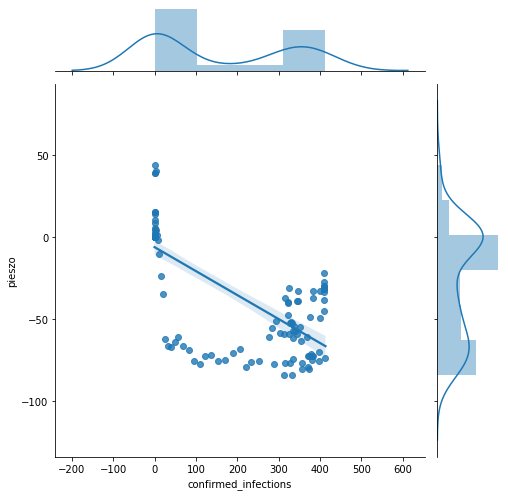

In [64]:
sns.jointplot(x="confirmed_infections", y="pieszo", data=df, kind = 'reg',fit_reg= True, height = 7)
plt.show()

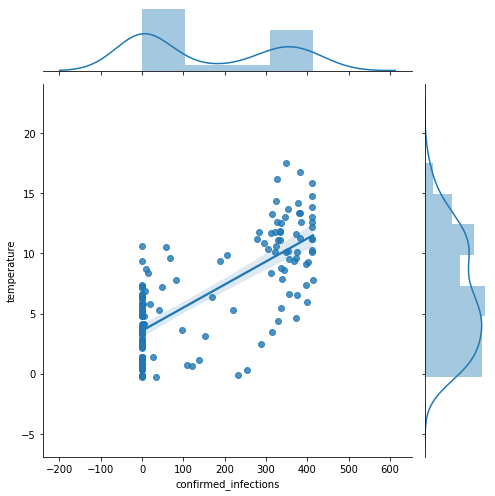

In [65]:
sns.jointplot(x="confirmed_infections", y="temperature", data=df, kind = 'reg',fit_reg= True, height = 7)
plt.show()

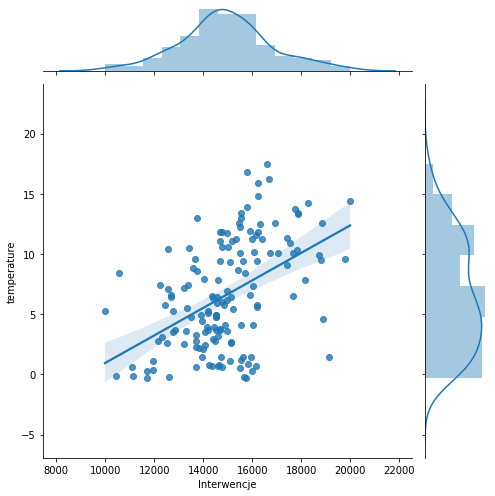

In [66]:
sns.jointplot(x="Interwencje", y="temperature", data=df, kind = 'reg',fit_reg= True, height = 7)
plt.show()

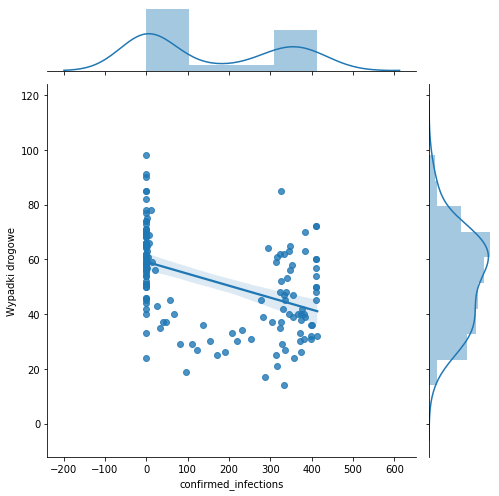

In [67]:
sns.jointplot(x="confirmed_infections", y="Wypadki drogowe", data=df, kind = 'reg',fit_reg= True, height = 7)
plt.show()

In [88]:
kmeans = cluster.KMeans(n_clusters = 3)
kmeans.fit(df[["confirmed_infections","temperature", "date"]])

KMeans(n_clusters=3)

In [89]:
d = pd.DataFrame(df[["confirmed_infections","temperature", "date"]])
d["label"] = pd.Series(kmeans.labels_).values

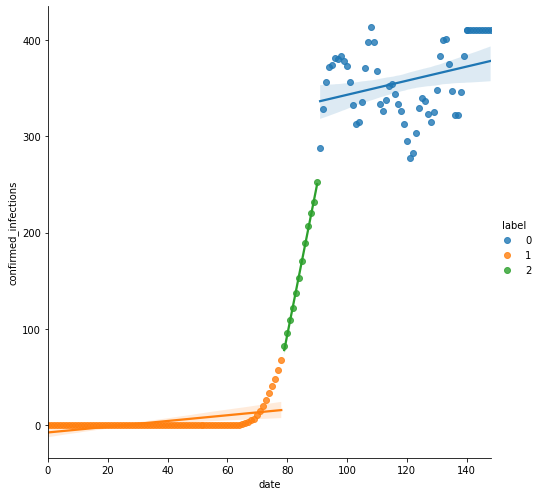

In [90]:
sns.lmplot(x="date", y="confirmed_infections", 
              data=d, fit_reg= True, height = 7, hue = "label")
plt.show()

In [91]:
df.columns

Index(['Unnamed: 0', 'Interwencje', 'Zatrzymani na gorącym uczynku',
       'Zatrzymani poszukiwani', 'Zatrzymani nietrzeźwi kierujący',
       'Wypadki drogowe', 'Zabici w wypadkach', 'Ranni w wypadkach',
       'temperature', 'temperature_min', 'temperature_max', 'winddirection',
       'windspeed', 'pressure', 'allbed_mean', 'ICUbed_mean', 'deaths_mean',
       'admis_mean', 'newICU_mean', 'totdea_mean', 'bedover_mean',
       'icuover_mean', 'mobility_composite', 'total_tests',
       'confirmed_infections', 'smp', 'testy', 'testyl', 'zar', 'chor', 'zgo',
       'wyl', 'pieszo', 'pojazdem', 'hosp', 'kwar', 'kwar_z', 'nadzor',
       'date'],
      dtype='object')

In [92]:
y = df["confirmed_infections"]
X = df[["pieszo", "Interwencje", "pojazdem"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
regressor = RandomForestRegressor(random_state=0, max_depth=3, n_estimators=5)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 41.80702023195276
Mean Squared Error: 6751.65700764005
Root Mean Squared Error: 82.1684672343354


In [93]:
pr = pd.DataFrame(X_test)
pr["confirmed_infections"] = y_pred
pr

,pieszo,Interwencje,pojazdem,confirmed_infections
2020-04-24,-54.74,17758.0,-38.72,330.958433
2020-03-03,5.40,14370.0,1.50,0.013662
2020-02-03,0.00,14162.0,0.00,0.013662
2020-04-17,-70.15,17399.0,-54.46,348.799704
2020-01-08,0.00,14078.0,0.00,0.013662
2020-04-10,-72.19,19801.0,-59.66,317.034691
2020-02-10,0.00,14958.0,0.00,0.013662
2020-03-27,-70.88,14679.0,-60.18,170.917620
2020-03-17,-64.23,13201.0,-54.73,162.302951
2020-03-12,-23.81,15685.0,-22.51,348.799704


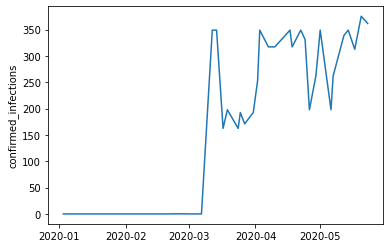

In [94]:
sns.lineplot(x=pr.index, y="confirmed_infections", 
              data=pr)
plt.show()

In [95]:
df2.columns

Index(['wojewodztwo', 'powierzchnina', 'ludnosc', 'gestosc_zal', 'urbanizacja',
       'stopa_bezrobocia', 'pdb_na_miesz', 'miasta', 'powiaty', 'm_powiaty',
       'gminy_ogolem', 'miejskie', 'wiejskie', 'miejsko_wiejskie', 'zar',
       'chor', 'zgo', 'wyl'],
      dtype='object')

In [99]:
cor_pearson = df2.corr(method="pearson")
cor_pearson.style.apply(highlight)

,powierzchnina,ludnosc,gestosc_zal,urbanizacja,stopa_bezrobocia,pdb_na_miesz,miasta,powiaty,m_powiaty,gminy_ogolem,miejskie,wiejskie,miejsko_wiejskie,zar,chor,zgo,wyl
powierzchnina,1.000000,0.478440,-0.246039,0.078817,-0.099544,0.549019,0.605576,0.841110,-0.081976,0.755835,0.297133,0.671827,0.531907,0.249512,0.139141,0.481569,0.478122
ludnosc,0.478440,1.000000,0.701411,0.311403,-0.636987,0.848677,0.717117,0.765147,0.610446,0.850579,0.809800,0.740178,0.331859,0.898084,0.843563,0.914376,0.935121
gestosc_zal,-0.246039,0.701411,1.000000,0.337647,-0.551019,0.394859,0.309888,0.127440,0.855445,0.303657,0.713457,0.240261,-0.093166,0.798909,0.848834,0.580352,0.606972
urbanizacja,0.078817,0.311403,0.337647,1.000000,-0.368414,0.454507,0.257631,0.091043,0.519627,0.001878,0.582246,-0.112345,-0.070363,0.527377,0.552644,0.363649,0.408673
stopa_bezrobocia,-0.099544,-0.636987,-0.551019,-0.368414,1.000000,-0.685165,-0.590221,-0.377262,-0.372201,-0.409910,-0.451727,-0.247810,-0.412909,-0.633897,-0.614085,-0.603552,-0.597853
pdb_na_miesz,0.549019,0.848677,0.394859,0.454507,-0.685165,1.000000,0.702754,0.781363,0.301727,0.736650,0.637216,0.604673,0.426972,0.776838,0.691282,0.894282,0.886061
miasta,0.605576,0.717117,0.309888,0.257631,-0.590221,0.702754,1.000000,0.824763,0.292108,0.675862,0.550359,0.396643,0.839499,0.655903,0.597916,0.723502,0.681304
powiaty,0.841110,0.765147,0.127440,0.091043,-0.377262,0.781363,0.824763,1.000000,0.109884,0.907436,0.526552,0.763075,0.645118,0.568777,0.452846,0.750178,0.770039
m_powiaty,-0.081976,0.610446,0.855445,0.519627,-0.372201,0.301727,0.292108,0.109884,1.000000,0.264790,0.817564,0.199767,-0.182212,0.781747,0.850539,0.566179,0.545921
gminy_ogolem,0.755835,0.850579,0.303657,0.001878,-0.409910,0.736650,0.675862,0.907436,0.264790,1.000000,0.588600,0.944648,0.426403,0.636919,0.532413,0.773975,0.827200


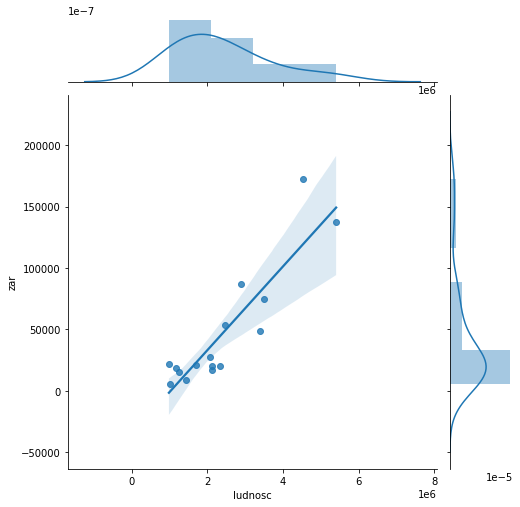

In [101]:
sns.jointplot(x="ludnosc", y="zar", data=df2, kind = 'reg',fit_reg= True, height = 7)
plt.show()

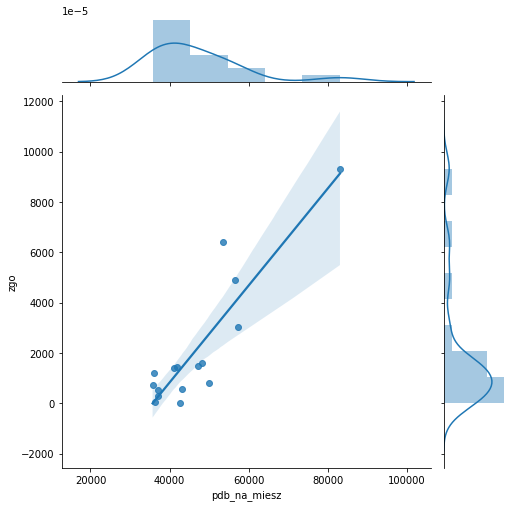

In [102]:
sns.jointplot(x="pdb_na_miesz", y="zgo", data=df2, kind = 'reg',fit_reg= True, height = 7)
plt.show()

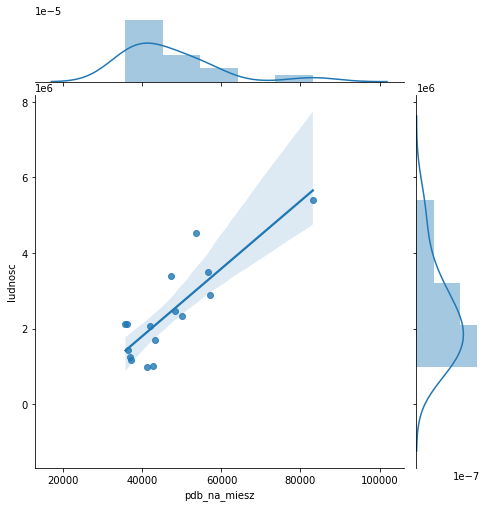

In [103]:
sns.jointplot(x="pdb_na_miesz", y="ludnosc", data=df2, kind = 'reg',fit_reg= True, height = 7)
plt.show()

In [115]:
kmeans = cluster.KMeans(n_clusters = 4)
kmeans.fit(df2[["zgo", "pdb_na_miesz"]])

KMeans(n_clusters=4)

In [116]:
d = pd.DataFrame(df2[["zgo","pdb_na_miesz"]])
d["label"] = pd.Series(kmeans.labels_).values

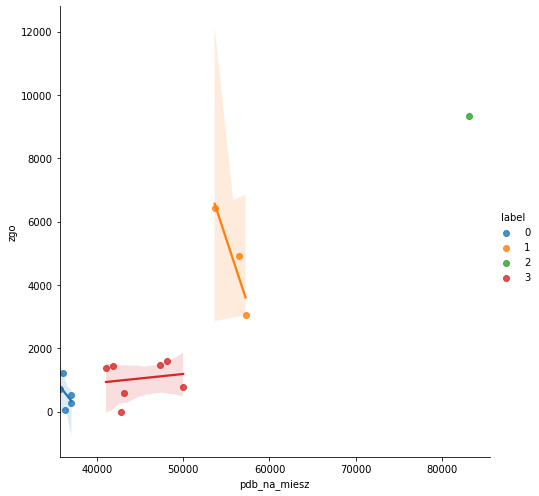

In [117]:
sns.lmplot(x="pdb_na_miesz", y="zgo", 
              data=d, fit_reg= True, height = 7, hue = "label")
plt.show()